# LSTM
CNN_264 with LSTM.

In [23]:
from datetime import datetime
print(datetime.now())

2023-03-27 20:47:23.883061


In [24]:
import tensorflow as tf
dt='float32'
tf.keras.backend.set_floatx('float32')
# tf.random.set_seed(42) # supposedly leads to reproducible results

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('GPU device not found')
else:
    print('Found GPU at: {}'.format(device_name))

try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/TrainTest/TrainTest_ver43/'  # must end in "/"
except:
    IN_COLAB = False
    DATA_DIR = 'D:/Adjeroh/Localization/TrainTest/'   # Windows
    DATA_DIR = '/Users/jasonmiller/WVU/Localization/TrainTest/TrainTest_ver43/'    # Mac
print(DATA_DIR)

Found GPU at: /device:GPU:0
Running on CoLab
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/


In [25]:
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
import scipy.stats as ss
import pickle
import time # sleep function
from os.path import isfile
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

from tensorflow import keras
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import matthews_corrcoef
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix

from keras.models import Sequential
from keras.layers import Masking
from keras.layers import Embedding
from keras.layers import Conv1D
from keras.layers import GlobalAveragePooling1D
from keras.layers import GlobalMaxPooling1D
from keras.layers import AveragePooling1D
from keras.layers import MaxPooling1D
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.losses import BinaryCrossentropy

K=4
CFILTERS=64 
FILTERSIZE=8
RCELLS=16
DCELLS=16
EPOCHS=8 # 20 
EMBED_DIMEN = 4 # arbitrary hyperparameter
# MINLEN=200   # NO LONGER USED
MAXLEN=5000   
PRETTY_PICTURES = True
RCI_THRESHOLD_MECHANISM = 'ZERO'  # 'RCI_GMM' 'ZERO' 'THE_MEAN'
BREAK = False   # break after first fold
EXCLUSIONS = [1]   # possibly exclude cell line 1 = H1.hESC

Python 3.9.16
sklearn 1.2.2


In [26]:
RCI_FILE_TRAIN = 'train.lncRNA_RCI.csv'
RCI_FILE_VALID = 'train.lncRNA_RCI.csv'
RCI_FILE_TEST  = None # else 'test.lncRNA_RCI.csv'

SEQ_FILE_TRAIN = 'train.canon_lncRNA_transcripts.csv'
SEQ_FILE_VALID = 'train.canon_lncRNA_transcripts.csv'
SEQ_FILE_TEST  = None # else 'test.canon_lncRNA_transcripts.csv'

In [27]:
def get_ordered_list():
    ordered_list = \
    ['A549','H1.hESC','HeLa.S3','HepG2','HT1080',\
      'HUVEC','MCF.7','NCI.H460','NHEK','SK.MEL.5',\
      'SK.N.DZ','SK.N.SH','GM12878','K562','IMR.90']
    return ordered_list
all_cell_lines = get_ordered_list()

## Data Load

In [28]:
class DataLoader():
    def __init__(self):
        self.cache=dict() 
        self.vals = {'A':0, 'C':1, 'G':2, 'T':3}
        self.gene2rci = dict()
        
    def load_gene_rci_values(self,filepath,exclusions):
        '''
        Load all the genes from the given RCI csv file.
        The given file usually contains train or test, not both.
        Load average RCI for each across cell lines.
        Define average as log of mean of antilogs: log2(mean(2^RCI)).
        Return dict with keys=gene:str and values=RCI:float.
        '''
        self.gene2rci = {}
        overall_sum = 0
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row # skip file's header line
                else:
                    line = row.strip()
                    fields = line.split(',')
                    gene_id = fields.pop(0)
                    cell_line_index = 0
                    rci_values = []
                    log_mean=0.0
                    for rci_str in fields:
                        if cell_line_index not in exclusions:
                            if rci_str != "nan":
                                rci_val = float(rci_str)
                                rci_values.append(rci_val)
                        cell_line_index += 1
                    if len(rci_values)>0:
                        values = np.array(rci_values)
                        antilogs = [2**x for x in values]
                        big_mean = np.mean(antilogs)
                        if np.absolute(big_mean)<0.000001:
                            log_mean = -1000000 # neg infinity
                        else:
                            log_mean = np.log2(big_mean) 
                        self.gene2rci[gene_id] = log_mean
                    # TO DO: get rid of this check on our log/antilog arithmetic.
                    if len(rci_values)==1:
                        diff = rci_values[0]-log_mean
                        if diff>0.000001:
                            print('antilog',log_mean,'not equal',rci_values,'for gene',gene_id)
        print('Number of RCI values loaded',len(self.gene2rci.keys()))
        return self.gene2rci

    def _seq_to_kmer_values(self,rna,K):
        vec=[] # seq converted to list of K-mers 
        N_indicator = 0 # indicator value
        length = len(rna)
        for i in range(length-K+1):
            kmer = rna[i:i+K]
            if 'N' in kmer:
                value = N_indicator
            elif kmer in self.cache.keys():
                value = self.cache[kmer]
            else:
                value = 0
                for j in range(K):
                    value *= 4   
                    nextnuc = kmer[j] 
                    nucval = self.vals[nextnuc]
                    value += nucval
                value += 1   # NNN => 0, AAA => 1
                self.cache[kmer] = value
            vec.append(value)
        return vec

    def load_sequence(self,filepath):
        '''
        Load all the sequences from the given file. 
        Load our version of GenCode -- csv, easier to parse than fasta.
        Each line has IDs plus sequence.
        The IDs in the file do not include dot-version numbers.
        The file may already be filtered e.g. canonical transcripts.
        '''
        allids=[]
        allseq=[]
        NREPEAT = str('N'*MAXLEN)
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row
                else:
                    line    = row.strip()
                    fields  = line.split(',')
                    tran_id = fields[0]  # without version number
                    gene_id = fields[1]  # without version number
                    seq_len = int(fields[3])
                    seq_txt = fields[4]
                    # Keep only transcripts having numeric RCI given the cell lines in use.
                    # We have validated this by spot checking.
                    # TO DO: validate this programmatically.
                    if gene_id in self.gene2rci.keys():
                        if seq_len<=MAXLEN:
                            seq_txt = seq_txt + NREPEAT
                        seq_txt = seq_txt[:MAXLEN]
                        allids.append( (gene_id,tran_id) )
                        hot_vec = self._seq_to_kmer_values(seq_txt,K)
                        allseq.append(hot_vec)
        self.cache=dict() # save RAM
        return allids,allseq

## Model

In [29]:
def build_model():
    ALPHABET=4**K+1  # NUMBER OF DISTINCT KMERS POSSIBLE, add one if N gets mask value
    ADJUST_LENGTH = MAXLEN-K+1  # fixed length sequences
    rnn = Sequential()
    embed_layer = Embedding(ALPHABET,EMBED_DIMEN,input_length=ADJUST_LENGTH,mask_zero=False)   
    rnn1_layer = Bidirectional( LSTM(RCELLS, return_sequences=True) )
    drop1_layer = Dropout(0.5) 
    dens_layer = TimeDistributed(Dense(DCELLS))
    flat_layer = Flatten()
    drop2_layer = Dropout(0.5) 
    output_layer = Dense(1,activation='sigmoid',dtype=dt)

    #rnn.add(mask_layer)
    rnn.add(embed_layer)
    rnn.add(rnn1_layer)
    rnn.add(drop1_layer)
    rnn.add(dens_layer)
    rnn.add(flat_layer)
    rnn.add(drop2_layer)
    rnn.add(output_layer)

    bc=BinaryCrossentropy(from_logits=False)
    rnn.compile(loss=bc, optimizer="Adam",metrics=["accuracy"])
    return rnn

In [30]:
print(datetime.now())
model=build_model()
print(model.summary())  # Print this only once
model=None

2023-03-27 20:47:27.837567
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 4997, 4)           1028      
                                                                 
 bidirectional_7 (Bidirectio  (None, 4997, 32)         2688      
 nal)                                                            
                                                                 
 dropout_9 (Dropout)         (None, 4997, 32)          0         
                                                                 
 time_distributed_7 (TimeDis  (None, 4997, 16)         528       
 tributed)                                                       
                                                                 
 flatten_7 (Flatten)         (None, 79952)             0         
                                                                 
 dropout_10 (Dropout)      

## Training

In [31]:
import gc
class CrossValidator():
    def __init__(self,epochs,quick_test=False,score_threshold=0.5):
        self.epochs = epochs
        self.quick_test = quick_test
        self.score_threshold = score_threshold
        self.mechanism = 'ZERO'
        self.discriminator = None
        self.flip = False
        self.reset_statistics()
        
    def reset_statistics(self):
        self.cv_accuracy=[]
        self.cv_precision=[]
        self.cv_recall=[]
        self.cv_f1=[]
        self.cv_auprc=[]
        self.cv_auroc=[]
        self.cv_mcc=[]
        
    def _get_X_y(self, all_ids, all_seqs, rci_map, exclude_middle=False): 
        # Prepare X and y for training or testing.
        subsetX=[]
        subsetY=[]
        for t in range(len(all_ids)):
            gene_id,tran_id = all_ids[t]
            oneX            = all_seqs[t]
            oneY            = rci_map[gene_id]
            if exclude_middle and oneY >= -2 and oneY <= 0:
                # Exclude middle from train set only, for comparison to Yuan et al
                continue
            subsetX.append(oneX)
            subsetY.append(oneY)
        subsetX = np.array(subsetX)
        subsetY = np.array(subsetY).reshape((-1,1))
        return subsetX,subsetY
    
    def set_threshold_mechanism(self, mechanism):
        if mechanism not in ['RCI_GMM','THE_MEAN','ZERO']:
            raise Exception('Unrecognized mechansm:',mechanism)
        self.mechanism = mechanism
    
    def _apply_threshold(self, array_of_rci):
        # Takes list of float, returns list of labels [0,1].
        if self.mechanism == 'RCI_GMM':
            labels = self.discriminator.predict(array_of_rci)
            if self.flip:
                IS_CYTO = lambda label: 1 if label==0 else 0
                labels = np.array(list(map(IS_CYTO, labels)))
        else:  # 'THE_MEAN' or 'ZERO'
            rci_threshold = self.discriminator
            IS_CYTO = lambda rci: 1 if rci>rci_threshold else 0
            labels = np.array(list(map(IS_CYTO, array_of_rci)))
        return labels
    
    def _prepare_threshold(self, rci_values, create=True):
        if self.mechanism == 'RCI_GMM':
            if create:  # during training, create a new GMM
                gmm = GaussianMixture(n_components=2, verbose=0, 
                  covariance_type='spherical', n_init=100) # random_state=42) 
                gmm.fit(rci_values)
            else:   # during testing, use existing GMM
                gmm=self.discriminator
            self.flip = False
            # The GMM labels are arbitrary.
            if gmm.means_[0][0] > gmm.means_[1][0]:
                self.flip = True
            self.discriminator = gmm   # redundant but consistent
        elif self.mechanism == 'THE_MEAN':
            self.discriminator = np.mean(rci_values)
        elif self.mechanism == 'ZERO':
            self.discriminator = -1   # 0 usually, -1 is as in Yuan et al.
        else: # not expected
            self.discriminator = 0
    
    def _explain_threshold(self):
        if self.mechanism == 'RCI_GMM':
            gmm=self.discriminator
            print('Discriminator is GMM')
            print('Means',[gmm.means_[0][0],gmm.means_[1][0]])
            print('Variances',gmm.covariances_)
            print('Priors',gmm.weights_)
            test_rcis=[-5,-4,-3.5,-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,3]
            print(test_rcis)
            print(self._apply_threshold(np.array(test_rcis).reshape((-1,1))))
        else:
            print('Discriminator',self.mechanism,self.discriminator)
    
    def _show_sizes(self,label,values):
        a = np.count_nonzero(values==1)
        b = np.count_nonzero(values==0)
        print('%s 1:0 %d:%d %5.2f%%'%(label,a,b,100*a/(a+b)))
        
    def train_new_model(self,train_ids,train_seq,train_rci,
            valid_ids=None,valid_seq=None,valid_rci=None):
        print(datetime.now())
        X_train,y_rci = self._get_X_y(train_ids,train_seq,train_rci) 
        self._prepare_threshold(y_rci,True)  
        self._explain_threshold()
        y_train = self._apply_threshold(y_rci)
        self._show_sizes('Train',y_train)
        cw = class_weight.compute_class_weight(
            'balanced', classes=[0,1], y=y_train)
        cwd = {0: cw[0], 1: cw[1]}
        print('Computed class weights:',cwd)
        if valid_ids is not None:
            X_valid,y_rci = self._get_X_y(valid_ids,valid_seq,valid_rci) 
            y_valid = self._apply_threshold(y_rci)
            self._show_sizes('Valid',y_valid)
        y_rci = None

        self.model=build_model()
        print("FIT")
        print(datetime.now())
        if valid_ids is None:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            class_weight=cwd) # no validation
        else:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            class_weight=cwd, 
            validation_data=(X_valid,y_valid) ) 

        if PRETTY_PICTURES:
            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1)
            plt.show()
        
    def test_without_training(self,test_ids,test_seq,test_rci):
        # For final test, do no train.
        # Assume set_sequences() set the test set.
        print(datetime.now())
        X_test,y_rci = self._get_X_y(test_ids,test_seq,test_rci) 
        y_test = self._apply_threshold(y_rci)
        y_rci = None
        
        print("PREDICT")
        print(datetime.now())        
        yhat_pred=self.model.predict(X_test, verbose=0)     
        yhat_classes=np.where(yhat_pred > self.score_threshold, 1, 0)

        self._show_sizes('Test',y_test)
        self._show_sizes('Predict',yhat_classes)
        print('Test sizes',X_test.shape,y_test.shape)
        print('Range of scores:',np.min(yhat_pred),'to',np.max(yhat_pred))
        print('Score threshold',self.score_threshold)
        cm1 = confusion_matrix(y_test,yhat_classes)
        print('Confusion matrix\n',cm1)
        cm2 = confusion_matrix(y_test,yhat_classes,normalize='all')
        print('Normalized matrix\n',cm2)

        accuracy = accuracy_score(y_test, yhat_classes)*100.
        precision = precision_score(y_test, yhat_classes)*100.
        recall = recall_score(y_test, yhat_classes)*100.
        f1 = f1_score(y_test, yhat_classes)*100.
        prc_Y, prc_X, prc_bins = precision_recall_curve(y_test, yhat_pred)
        auprc = auc(prc_X,prc_Y)*100.
        auroc = roc_auc_score(y_test, yhat_pred)*100.
        mcc = matthews_corrcoef(y_test, yhat_classes)
        if PRETTY_PICTURES:
            self._pretty_pictures(y_test,yhat_pred,prc_X,prc_Y)
            print('Accuracy: %.2f%% Precision: %.2f%% Recall: %.2f%%' % (accuracy,precision,recall)) 
            print('F1: %.2f%% MCC: %.4f' % (f1,mcc)) 
            print('AUPRC: %.2f%% AUROC: %.2f%%' % (auprc,auroc)) 
        self.cv_accuracy.append(accuracy)
        self.cv_precision.append(precision)
        self.cv_recall.append(recall)
        self.cv_f1.append(f1)
        self.cv_mcc.append(mcc)
        self.cv_auprc.append(auprc)
        self.cv_auroc.append(auroc)

    def _pretty_pictures(self,y_valid,yhat_pred,prc_X,prc_Y):
        count_ones= len(y_valid[y_valid==1])
        count_zeros= len(y_valid[y_valid==0])
        guess = max(count_ones,count_zeros) / len(y_valid)
        # PRC
        plt.plot(prc_X, prc_Y, marker='.')
        plt.plot([0, 1], [guess,guess], linestyle='--')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.show()
        # ROC
        fpr, tpr, roc_bins = roc_curve(y_valid, yhat_pred)
        plt.plot(fpr, tpr, marker='.')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.show()
        
    def get_statistics(self):
        return \
        self.cv_accuracy,\
        self.cv_precision,\
        self.cv_recall,\
        self.cv_f1,\
        self.cv_mcc,\
        self.cv_auprc,\
        self.cv_auroc


## Train

In [32]:
class Separator():
    def __init__(self):
        self.train_ids = []
        self.train_seq = []
        self.train_rci = dict()
        self.val_ids = []
        self.val_seq = []
        self.val_rci = dict()
    def load(self,data_dir,rep,fold):
        filename='cv.{}.{}.validation_genes.txt'.format(rep,fold)
        filename = data_dir + filename
        self.val_genes = set()
        with open(filename,'r') as fin:
            for line in fin:
                gene_id = line.strip()
                self.val_genes.add(gene_id)
    def process(self,allids,allseq,gene_to_rci):
        size = len(allids)
        for t in range(size):
            gene_id,tran_id = allids[t]
            oneX            = allseq[t]
            oneY            = gene_to_rci[gene_id]
            if gene_id in self.val_genes:
                self.val_ids.append(allids[t])
                self.val_seq.append(allseq[t])
                self.val_rci[gene_id]=gene_to_rci[gene_id]
            else:
                self.train_ids.append(allids[t])
                self.train_seq.append(allseq[t])
                self.train_rci[gene_id]=gene_to_rci[gene_id]
    def get_ids(self):
        return self.train_ids,self.val_ids
    def get_seq(self):
        return self.train_seq,self.val_seq
    def get_rci(self):
        return self.train_rci,self.val_rci

2023-03-27 20:47:29.065449
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.lncRNA_RCI.csv
Number of RCI values loaded 4369
Num RCI: 4369
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.canon_lncRNA_transcripts.csv
Loaded 4369 sequences.
2023-03-27 20:47:39.116596

Training # 1 1
2023-03-27 20:47:39.116889
2023-03-27 20:47:39.116943
Discriminator ZERO -1
Train 1:0 1800:1699 51.44%
Computed class weights: {0: 1.029723366686286, 1: 0.9719444444444445}
Valid 1:0 458:412 52.64%
FIT
2023-03-27 20:47:40.819662


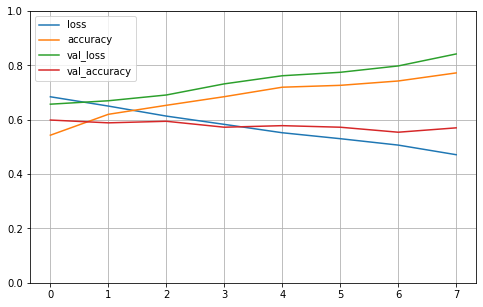


2023-03-27 20:51:06.149281

Testing # 1 1
2023-03-27 20:51:06.149386
2023-03-27 20:51:06.149425
PREDICT
2023-03-27 20:51:06.364278
Test 1:0 458:412 52.64%
Predict 1:0 478:392 54.94%
Test sizes (870, 4997) (870,)
Range of scores: 0.0019388907 to 0.9978023
Score threshold 0.5
Confusion matrix
 [[215 197]
 [177 281]]
Normalized matrix
 [[0.24712644 0.22643678]
 [0.20344828 0.32298851]]


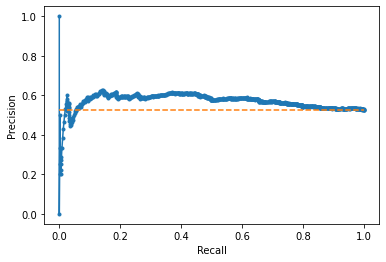

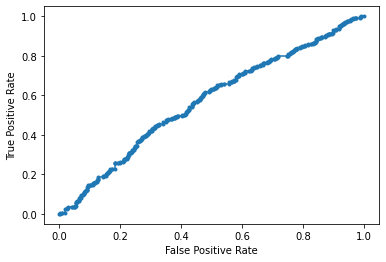

Accuracy: 57.01% Precision: 58.79% Recall: 61.35%
F1: 60.04% MCC: 0.1359
AUPRC: 56.97% AUROC: 57.05%
 accuracy [57.01149425287356]
 precision [58.78661087866108]
 recall [61.35371179039302]
 F1 [60.04273504273504]
 MCC [0.13585780043746154]
 AUPRC [56.97357948921713]
 AUROC [57.04943401025988]
2023-03-27 20:51:12.763727

Training # 1 2
2023-03-27 20:51:12.765189
2023-03-27 20:51:12.765242
Discriminator ZERO -1
Train 1:0 1816:1669 52.11%
Computed class weights: {0: 1.0440383463151588, 1: 0.9595264317180616}
Valid 1:0 442:442 50.00%
FIT
2023-03-27 20:51:14.353018


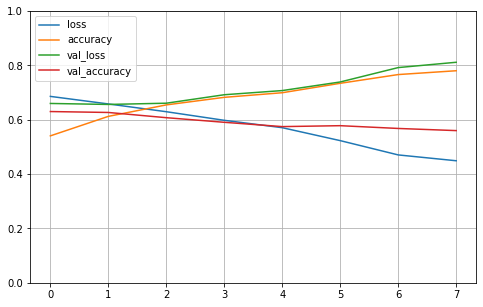


2023-03-27 20:54:40.170914

Testing # 1 2
2023-03-27 20:54:40.171021
2023-03-27 20:54:40.171058
PREDICT
2023-03-27 20:54:40.390020
Test 1:0 442:442 50.00%
Predict 1:0 429:455 48.53%
Test sizes (884, 4997) (884,)
Range of scores: 0.0014530766 to 0.9915507
Score threshold 0.5
Confusion matrix
 [[254 188]
 [201 241]]
Normalized matrix
 [[0.28733032 0.21266968]
 [0.22737557 0.27262443]]


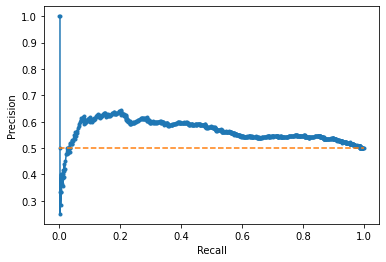

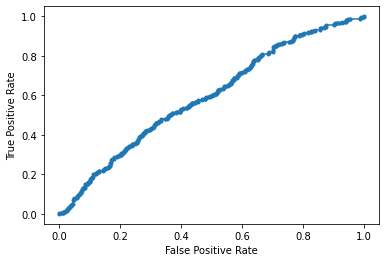

Accuracy: 56.00% Precision: 56.18% Recall: 54.52%
F1: 55.34% MCC: 0.1200
AUPRC: 56.60% AUROC: 59.40%
 accuracy [55.995475113122176]
 precision [56.17715617715617]
 recall [54.52488687782805]
 F1 [55.33869115958667]
 MCC [0.1199613999070557]
 AUPRC [56.598595927205366]
 AUROC [59.400913167216075]
2023-03-27 20:54:43.927006

Training # 1 3
2023-03-27 20:54:43.932069
2023-03-27 20:54:43.932112
Discriminator ZERO -1
Train 1:0 1816:1704 51.59%
Computed class weights: {0: 1.0328638497652582, 1: 0.9691629955947136}
Valid 1:0 442:407 52.06%
FIT
2023-03-27 20:54:45.488420


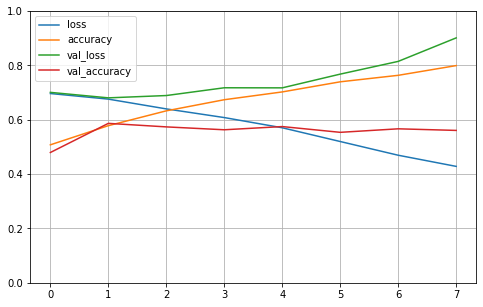


2023-03-27 20:58:10.300150

Testing # 1 3
2023-03-27 20:58:10.300246
2023-03-27 20:58:10.300282
PREDICT
2023-03-27 20:58:10.511516
Test 1:0 442:407 52.06%
Predict 1:0 589:260 69.38%
Test sizes (849, 4997) (849,)
Range of scores: 0.0015193304 to 0.99961495
Score threshold 0.5
Confusion matrix
 [[147 260]
 [113 329]]
Normalized matrix
 [[0.17314488 0.30624264]
 [0.13309776 0.38751472]]


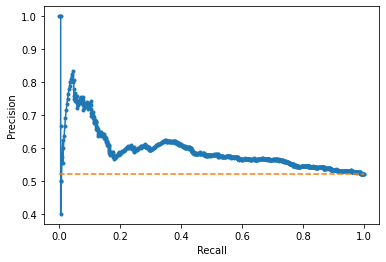

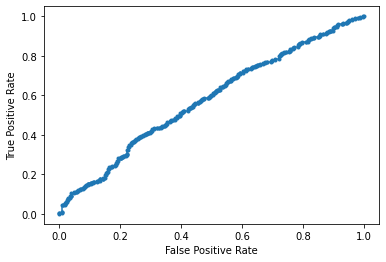

Accuracy: 56.07% Precision: 55.86% Recall: 74.43%
F1: 63.82% MCC: 0.1144
AUPRC: 59.34% AUROC: 57.76%
 accuracy [56.06595995288575]
 precision [55.85738539898133]
 recall [74.43438914027149]
 F1 [63.82153249272551]
 MCC [0.11437001737118596]
 AUPRC [59.33554088096974]
 AUROC [57.76068129009306]
2023-03-27 20:58:14.682526

Training # 1 4
2023-03-27 20:58:14.682664
2023-03-27 20:58:14.682707
Discriminator ZERO -1
Train 1:0 1799:1680 51.71%
Computed class weights: {0: 1.0354166666666667, 1: 0.9669260700389105}
Valid 1:0 459:431 51.57%
FIT
2023-03-27 20:58:16.290537


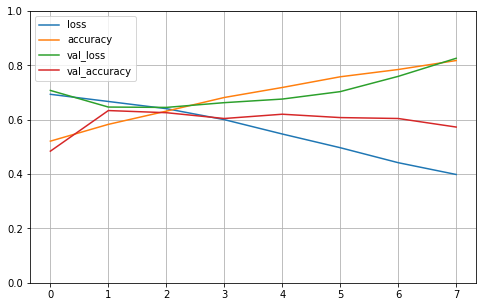


2023-03-27 21:01:21.744271

Testing # 1 4
2023-03-27 21:01:21.744361
2023-03-27 21:01:21.744394
PREDICT
2023-03-27 21:01:21.963999
Test 1:0 459:431 51.57%
Predict 1:0 405:485 45.51%
Test sizes (890, 4997) (890,)
Range of scores: 0.00013209827 to 0.997677
Score threshold 0.5
Confusion matrix
 [[268 163]
 [217 242]]
Normalized matrix
 [[0.3011236  0.18314607]
 [0.24382022 0.27191011]]


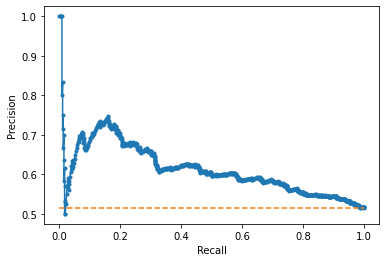

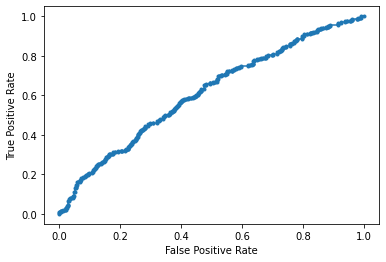

Accuracy: 57.30% Precision: 59.75% Recall: 52.72%
F1: 56.02% MCC: 0.1496
AUPRC: 61.35% AUROC: 61.15%
 accuracy [57.30337078651685]
 precision [59.75308641975309]
 recall [52.723311546840954]
 F1 [56.01851851851851]
 MCC [0.14957457356774062]
 AUPRC [61.353335118083955]
 AUROC [61.149275384296544]
2023-03-27 21:01:25.945503

Training # 1 5
2023-03-27 21:01:25.947392
2023-03-27 21:01:25.947729
Discriminator ZERO -1
Train 1:0 1801:1692 51.56%
Computed class weights: {0: 1.032210401891253, 1: 0.9697390338700722}
Valid 1:0 457:419 52.17%
FIT
2023-03-27 21:01:28.655574


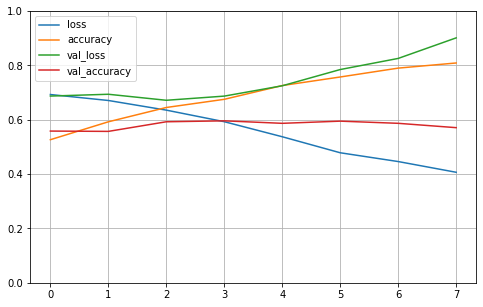


2023-03-27 21:04:34.758706

Testing # 1 5
2023-03-27 21:04:34.758815
2023-03-27 21:04:34.758851
PREDICT
2023-03-27 21:04:34.982009
Test 1:0 457:419 52.17%
Predict 1:0 403:473 46.00%
Test sizes (876, 4997) (876,)
Range of scores: 9.461298e-05 to 0.9986811
Score threshold 0.5
Confusion matrix
 [[258 161]
 [215 242]]
Normalized matrix
 [[0.29452055 0.18378995]
 [0.24543379 0.27625571]]


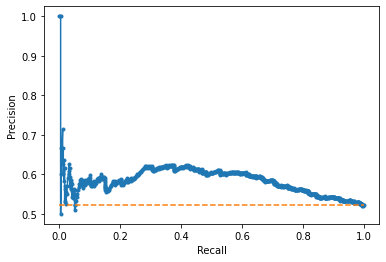

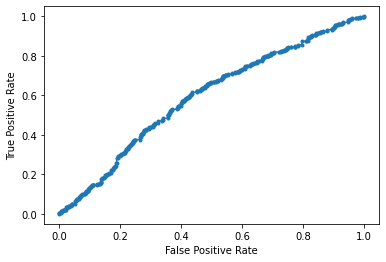

Accuracy: 57.08% Precision: 60.05% Recall: 52.95%
F1: 56.28% MCC: 0.1456
AUPRC: 58.46% AUROC: 59.28%
 accuracy [57.077625570776256]
 precision [60.049627791563275]
 recall [52.95404814004377]
 F1 [56.27906976744185]
 MCC [0.14562117509735303]
 AUPRC [58.45702486668195]
 AUROC [59.28437511423991]
2023-03-27 21:04:39.336700

Training # 2 1
2023-03-27 21:04:39.336897
2023-03-27 21:04:39.336944
Discriminator ZERO -1
Train 1:0 1786:1696 51.29%
Computed class weights: {0: 1.0265330188679245, 1: 0.9748040313549832}
Valid 1:0 472:415 53.21%
FIT
2023-03-27 21:04:40.912867


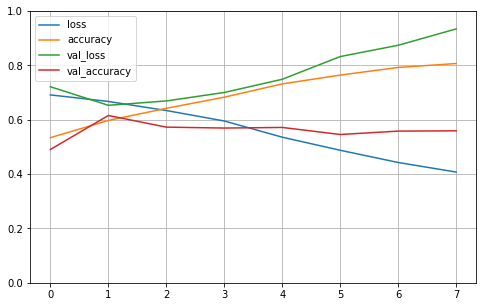


2023-03-27 21:08:06.318400

Testing # 2 1
2023-03-27 21:08:06.318494
2023-03-27 21:08:06.318530
PREDICT
2023-03-27 21:08:06.543566
Test 1:0 472:415 53.21%
Predict 1:0 535:352 60.32%
Test sizes (887, 4997) (887,)
Range of scores: 0.00045960065 to 0.99932206
Score threshold 0.5
Confusion matrix
 [[188 227]
 [164 308]]
Normalized matrix
 [[0.21195039 0.25591883]
 [0.1848929  0.34723788]]


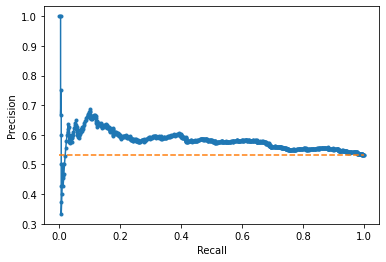

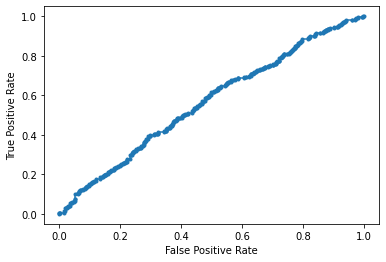

Accuracy: 55.92% Precision: 57.57% Recall: 65.25%
F1: 61.17% MCC: 0.1077
AUPRC: 58.13% AUROC: 56.46%
 accuracy [55.91882750845547]
 precision [57.570093457943926]
 recall [65.2542372881356]
 F1 [61.17179741807348]
 MCC [0.10765228514659907]
 AUPRC [58.1297164359446]
 AUROC [56.45752501531549]
2023-03-27 21:08:10.871634

Training # 2 2
2023-03-27 21:08:10.873018
2023-03-27 21:08:10.873072
Discriminator ZERO -1
Train 1:0 1806:1695 51.59%
Computed class weights: {0: 1.0327433628318583, 1: 0.9692691029900332}
Valid 1:0 452:416 52.07%
FIT
2023-03-27 21:08:12.446719


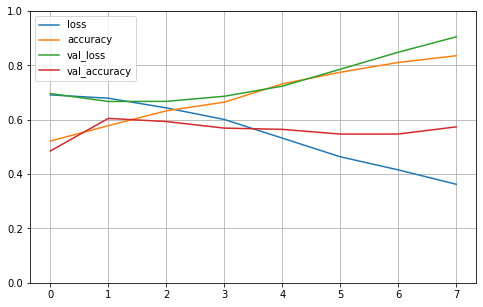


2023-03-27 21:11:21.372526

Testing # 2 2
2023-03-27 21:11:21.372621
2023-03-27 21:11:21.372658
PREDICT
2023-03-27 21:11:21.600724
Test 1:0 452:416 52.07%
Predict 1:0 448:420 51.61%
Test sizes (868, 4997) (868,)
Range of scores: 0.00024361393 to 0.9996075
Score threshold 0.5
Confusion matrix
 [[233 183]
 [187 265]]
Normalized matrix
 [[0.26843318 0.21082949]
 [0.21543779 0.30529954]]


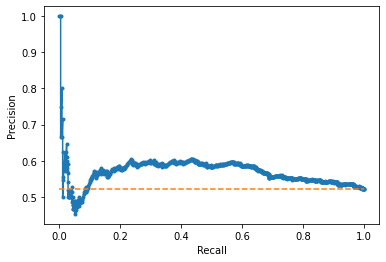

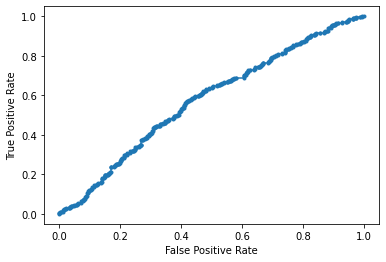

Accuracy: 57.37% Precision: 59.15% Recall: 58.63%
F1: 58.89% MCC: 0.1463
AUPRC: 56.94% AUROC: 57.67%
 accuracy [57.373271889400925]
 precision [59.15178571428571]
 recall [58.62831858407079]
 F1 [58.88888888888888]
 MCC [0.14632954232543205]
 AUPRC [56.941174972172284]
 AUROC [57.67156654186522]
2023-03-27 21:11:26.005398

Training # 2 3
2023-03-27 21:11:26.005585
2023-03-27 21:11:26.005634
Discriminator ZERO -1
Train 1:0 1805:1704 51.44%
Computed class weights: {0: 1.0296361502347418, 1: 0.97202216066482}
Valid 1:0 453:407 52.67%
FIT
2023-03-27 21:11:27.569398


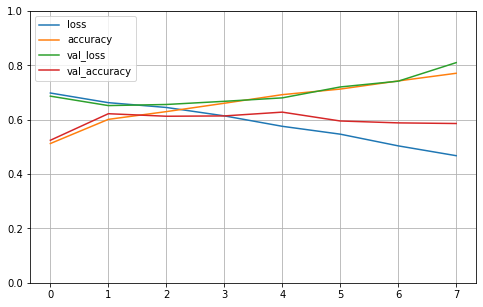


2023-03-27 21:14:52.809159

Testing # 2 3
2023-03-27 21:14:52.809260
2023-03-27 21:14:52.809300
PREDICT
2023-03-27 21:14:53.023322
Test 1:0 453:407 52.67%
Predict 1:0 345:515 40.12%
Test sizes (860, 4997) (860,)
Range of scores: 0.0011829169 to 0.9938892
Score threshold 0.5
Confusion matrix
 [[283 124]
 [232 221]]
Normalized matrix
 [[0.32906977 0.14418605]
 [0.26976744 0.25697674]]


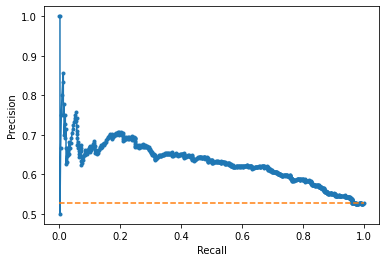

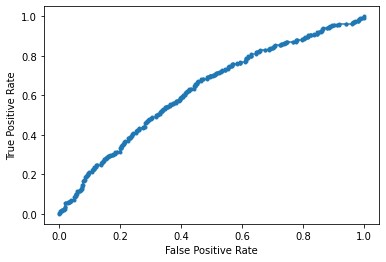

Accuracy: 58.60% Precision: 64.06% Recall: 48.79%
F1: 55.39% MCC: 0.1866
AUPRC: 62.97% AUROC: 62.64%
 accuracy [58.6046511627907]
 precision [64.05797101449275]
 recall [48.78587196467991]
 F1 [55.388471177944865]
 MCC [0.18661041986453641]
 AUPRC [62.96685754232571]
 AUROC [62.64488449918913]
2023-03-27 21:14:57.424948

Training # 2 4
2023-03-27 21:14:57.425788
2023-03-27 21:14:57.425838
Discriminator ZERO -1
Train 1:0 1826:1664 52.32%
Computed class weights: {0: 1.0486778846153846, 1: 0.9556407447973713}
Valid 1:0 432:447 49.15%
FIT
2023-03-27 21:14:59.018462


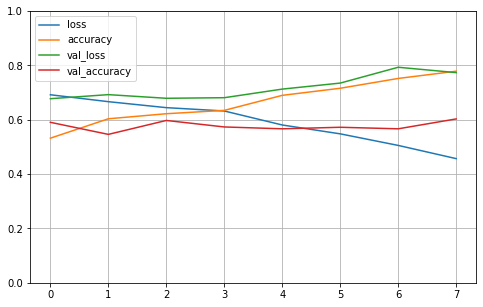


2023-03-27 21:18:24.349192

Testing # 2 4
2023-03-27 21:18:24.349299
2023-03-27 21:18:24.349335
PREDICT
2023-03-27 21:18:24.570467
Test 1:0 432:447 49.15%
Predict 1:0 443:436 50.40%
Test sizes (879, 4997) (879,)
Range of scores: 0.00063460064 to 0.9957624
Score threshold 0.5
Confusion matrix
 [[267 180]
 [169 263]]
Normalized matrix
 [[0.30375427 0.20477816]
 [0.19226394 0.29920364]]


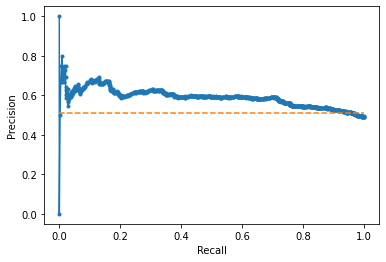

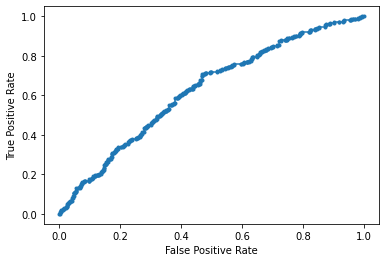

Accuracy: 60.30% Precision: 59.37% Recall: 60.88%
F1: 60.11% MCC: 0.2061
AUPRC: 58.91% AUROC: 62.67%
 accuracy [60.2957906712173]
 precision [59.36794582392777]
 recall [60.879629629629626]
 F1 [60.11428571428571]
 MCC [0.20608825460187954]
 AUPRC [58.906580432557185]
 AUROC [62.66519595658298]
2023-03-27 21:18:28.910348

Training # 2 5
2023-03-27 21:18:28.910533
2023-03-27 21:18:28.910581
Discriminator ZERO -1
Train 1:0 1809:1685 51.77%
Computed class weights: {0: 1.0367952522255193, 1: 0.9657269209508016}
Valid 1:0 449:426 51.31%
FIT
2023-03-27 21:18:30.478754


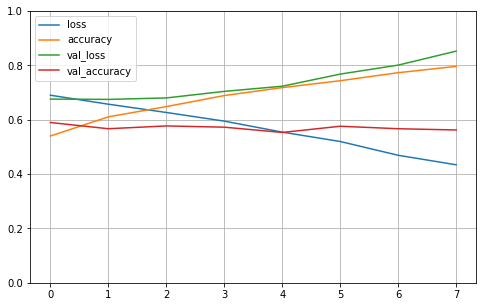


2023-03-27 21:21:41.887365

Testing # 2 5
2023-03-27 21:21:41.887674
2023-03-27 21:21:41.887713
PREDICT
2023-03-27 21:21:42.102505
Test 1:0 449:426 51.31%
Predict 1:0 402:473 45.94%
Test sizes (875, 4997) (875,)
Range of scores: 0.0013718532 to 0.9981223
Score threshold 0.5
Confusion matrix
 [[258 168]
 [215 234]]
Normalized matrix
 [[0.29485714 0.192     ]
 [0.24571429 0.26742857]]


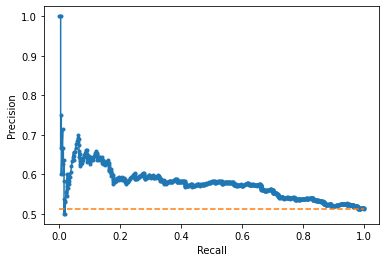

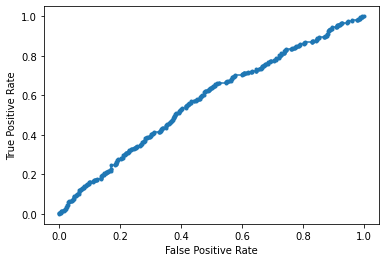

Accuracy: 56.23% Precision: 58.21% Recall: 52.12%
F1: 54.99% MCC: 0.1272
AUPRC: 57.63% AUROC: 57.57%
 accuracy [56.22857142857143]
 precision [58.2089552238806]
 recall [52.11581291759465]
 F1 [54.99412455934194]
 MCC [0.12716745873384658]
 AUPRC [57.63233623776678]
 AUROC [57.57186026328722]
2023-03-27 21:21:45.345687


In [33]:
print(datetime.now())

accuracy=[]
precision=[]
recall=[]
f1=[]
mcc=[]
auprc=[]
auroc=[]

loader = DataLoader()
filepath = DATA_DIR+RCI_FILE_TRAIN
print("Load RCI from",filepath)
gene_to_rci = loader.load_gene_rci_values(filepath,EXCLUSIONS)
print('Num RCI:', len(gene_to_rci.keys()))
filepath = DATA_DIR+SEQ_FILE_TRAIN
print('Load sequence from',filepath)
allids,allseq = loader.load_sequence(filepath)
print('Loaded',len(allseq),'sequences.')
test_gene_to_rci = None
test_allids = None
test_allseq = None
if SEQ_FILE_TEST is not None:
    # Train on the entire train set (no cross-validation).
    # Evaluate with the test files.
    test_loader = DataLoader()
    filepath = DATA_DIR+RCI_FILE_TEST
    print("Load RCI from",filepath)
    test_gene_to_rci = test_loader.load_gene_rci_values(filepath,EXCLUSIONS)
    print('Num RCI:', len(test_gene_to_rci.keys()))
    filepath = DATA_DIR+SEQ_FILE_TEST
    print('Load sequence from',filepath)
    test_allids,test_allseq = test_loader.load_sequence(filepath)
    print('Loaded',len(test_allseq),'sequences.')

REPEATS = 2
FOLDS = 5
for repeat in range(REPEATS):
    for fold in range(FOLDS):
        r = repeat+1
        f = fold+1

        if SEQ_FILE_TEST is None:
            # Train on 80% and evaluate on 20%.
            separator = Separator()
            separator.load(DATA_DIR,r,f)
            separator.process(allids,allseq,gene_to_rci)
            train_allids,test_allids = separator.get_ids()
            train_allseq,test_allseq = separator.get_seq()
            train_gene_to_rci,test_gene_to_rci = separator.get_rci()
        else:
            # Train on the entire train set (no cross-validation).
            # Evaluate with the test files.
            train_allids = allids
            train_allseq = allseq
            train_gene_to_rci = gene_to_rci
            test_allids = None
            test_allseq = None
            test_gene_to_rci = None
            
        print(datetime.now())
        print()
        print("Training #",r,f)
        print(datetime.now())
        cvdo = CrossValidator(EPOCHS,BREAK)
        cvdo.set_threshold_mechanism(RCI_THRESHOLD_MECHANISM)
        cvdo.train_new_model(
            train_allids,train_allseq,train_gene_to_rci,
            test_allids,test_allseq,test_gene_to_rci)
           
        print()
        print(datetime.now())
        print()
        print("Testing #",r,f)
        print(datetime.now())
        cvdo.reset_statistics()
        cvdo.test_without_training(
            test_allids,test_allseq,test_gene_to_rci)
        cv_accuracy,cv_precision,cv_recall,cv_f1,cv_mcc,cv_auprc,cv_auroc=\
            cvdo.get_statistics()

        print(" accuracy" ,  cv_accuracy)
        print(" precision" , cv_precision)
        print(" recall" ,    cv_recall)
        print(" F1" ,        cv_f1)
        print(" MCC" ,       cv_mcc)
        print(" AUPRC" ,     cv_auprc)
        print(" AUROC" ,     cv_auroc)

        accuracy.append(cv_accuracy)
        precision.append(cv_precision)
        recall.append(cv_recall)
        f1.append(cv_f1)
        mcc.append(cv_mcc)
        auprc.append(cv_auprc)
        auroc.append(cv_auroc)
        if BREAK: break
    if BREAK: break
print(datetime.now())

In [34]:
def STD (values):
    return np.std(values,ddof=1)

print(" accuracy mean %.2f%% std %.2f" %  (np.mean(accuracy),  STD(accuracy)))
print(" precision mean %.2f%% std %.2f" % (np.mean(precision), STD(precision)))
print(" recall mean %.2f%% std %.2f" %    (np.mean(recall),    STD(recall)))
print(" F1 mean %.2f%% std %.2f" %        (np.mean(f1),        STD(f1)))
print(" MCC mean %.2f%% std %.2f" %       (np.mean(mcc),       STD(mcc)))
print(" AUPRC mean %.2f%% std %.2f" %     (np.mean(auprc),     STD(auprc)))
print(" AUROC mean %.2f%% std %.2f" %     (np.mean(auroc),     STD(auroc)))

print(" accuracy"  , accuracy)
print(" precision" , precision)
print(" recall"    , recall)
print(" F1"        , f1)
print(" MCC"       , mcc)
print(" AUPRC"     , auprc)
print(" AUROC"     , auroc)



 accuracy mean 57.19% std 1.37
 precision mean 58.90% std 2.31
 recall mean 58.17% std 7.65
 F1 mean 58.21% std 3.03
 MCC mean 0.14% std 0.03
 AUPRC mean 58.73% std 2.05
 AUROC mean 59.17% std 2.28
 accuracy [[57.01149425287356], [55.995475113122176], [56.06595995288575], [57.30337078651685], [57.077625570776256], [55.91882750845547], [57.373271889400925], [58.6046511627907], [60.2957906712173], [56.22857142857143]]
 precision [[58.78661087866108], [56.17715617715617], [55.85738539898133], [59.75308641975309], [60.049627791563275], [57.570093457943926], [59.15178571428571], [64.05797101449275], [59.36794582392777], [58.2089552238806]]
 recall [[61.35371179039302], [54.52488687782805], [74.43438914027149], [52.723311546840954], [52.95404814004377], [65.2542372881356], [58.62831858407079], [48.78587196467991], [60.879629629629626], [52.11581291759465]]
 F1 [[60.04273504273504], [55.33869115958667], [63.82153249272551], [56.01851851851851], [56.27906976744185], [61.17179741807348], [58.88